# Visualising Electricity Access Over Space and Time

In this post, I'll explore electricity access, i.e. globally what fraction of people have access to electricity. Beyond the goal of finding the electricity access, this post will also serve to illustrate how the `coolness` coefficient of the Python visualisation ecosystem!

I'll be using data from World Bank for electricity access. See the image below for the [corresponding page](https://data.worldbank.org/indicator/EG.ELC.ACCS.ZS).

![](world-bank.png)

### Downloading World Bank data

Now, a Python package called [`wbdata`](http://wbdata.readthedocs.io) provides a fairly easy way to access World Bank data. I'd be using it to get data in Pandas `DataFrame`.

In [1]:
%matplotlib inline
import pandas as pd
import wbdata
import matplotlib.pyplot as plt
import datetime
data_date = (datetime.datetime(1990, 1, 1), datetime.datetime(2016, 1, 1))
df_elec = wbdata.get_data("EG.ELC.ACCS.ZS", pandas=True, data_date=data_date)

In [2]:
df_elec.head()

country     date
Arab World  2016    88.768654
            2015    88.517967
            2014    88.076774
            2013    88.389705
            2012    87.288244
Name: value, dtype: float64

### Downloading Geodata and Reading Using GeoPandas

I'd now be downloading `shapefile` data for different countries. This will help us to spatially plot the data for the different countries.

In [4]:
!wget http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries_lakes.zip

--2018-06-26 15:52:50--  http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries_lakes.zip
Resolving naciscdn.org (naciscdn.org)... 146.201.97.163
Connecting to naciscdn.org (naciscdn.org)|146.201.97.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5077755 (4.8M) [application/x-zip-compressed]
Saving to: ‘ne_10m_admin_0_countries_lakes.zip’

ne_10m_admin_0_coun 100%[===================>]   4.84M   246KB/s    in 22s     

2018-06-26 15:53:12 (228 KB/s) - ‘ne_10m_admin_0_countries_lakes.zip’ saved [5077755/5077755]



#### Extracting shapefile

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('ne_10m_admin_0_countries_lakes.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [6]:
import geopandas as gpd
gdf = gpd.read_file('ne_10m_admin_0_countries_lakes.shp')[['ADM0_A3', 'geometry']]

In [7]:
gdf.head()

,ADM0_A3,geometry
0,IDN,(POLYGON ((117.7036079039552 4.163414542001791...
1,MYS,(POLYGON ((117.7036079039552 4.163414542001791...
2,CHL,(POLYGON ((-69.51008875199994 -17.506588197999...
3,BOL,POLYGON ((-69.51008875199994 -17.5065881979999...
4,PER,(POLYGON ((-69.51008875199994 -17.506588197999...


### Visualising electricity access in 2016

#### Getting electricity access data for 2016

In [8]:
df_2016 = df_elec.unstack()[['2016']].dropna()

In [9]:
df_2016.head()

date,2016
country,
Afghanistan,84.137138
Albania,100.000000
Algeria,99.439568
Andorra,100.000000
Angola,40.520607


In order to visualise electricity access data over the map, we would have to join the GeoPandas object `gdf` and `df_elec`

#### Joining `gdf` and `df_2016`

Now, `gdf` uses `alpha_3` codes for country names like AFG, etc., whereas `df_2016` uses country names. We will thus use `pycountry` package to get code names corresponding to countries in `df_2016` as shown in this [StackOverflow post](https://stackoverflow.com/questions/16253060/how-to-convert-country-names-to-iso-3166-1-alpha-2-values-using-python).

In [11]:
import pycountry
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
codes = [countries.get(country, 'Unknown code') for country in df_2016.index]
df_2016['Code'] = codes

In [12]:
df_2016.head()

date,2016,Code
country,,
Afghanistan,84.137138,AFG
Albania,100.000000,ALB
Algeria,99.439568,DZA
Andorra,100.000000,AND
Angola,40.520607,AGO


Now, we can join the two data sources

In [13]:
merged_df_2016 = gpd.GeoDataFrame(pd.merge(gdf, df_2016, left_on='ADM0_A3', right_on='Code'))

In [14]:
merged_df_2016.head()

,ADM0_A3,geometry,2016,Code
0,IDN,(POLYGON ((117.7036079039552 4.163414542001791...,97.620000,IDN
1,MYS,(POLYGON ((117.7036079039552 4.163414542001791...,100.000000,MYS
2,CHL,(POLYGON ((-69.51008875199994 -17.506588197999...,100.000000,CHL
3,PER,(POLYGON ((-69.51008875199994 -17.506588197999...,94.851746,PER
4,ARG,(POLYGON ((-68.4486097329999 -52.3466170159999...,100.000000,ARG


#### Finally plotting!

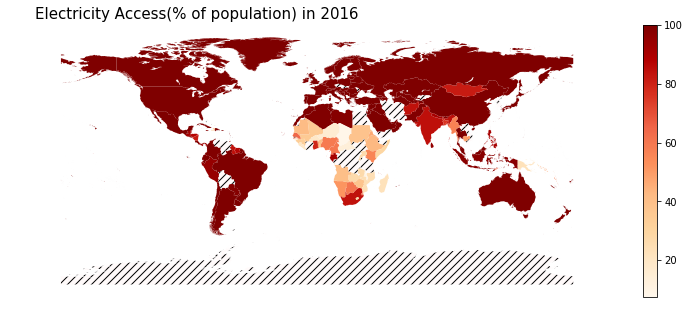

In [16]:
# Example borrowed from http://ramiro.org/notebook/geopandas-choropleth/
cmap='OrRd'
figsize = (16, 5)
ax = merged_df_2016.plot(column='2016', cmap=cmap, figsize=figsize,legend=True)
title = 'Electricity Access(% of population) in {}'.format('2016')
gdf[~gdf.ADM0_A3.isin(merged_df_2016.ADM0_A3)].plot(ax=ax, color='#fffafa', hatch='///')
ax.set_title(title, fontdict={'fontsize': 15}, loc='left')
ax.set_axis_off()

### Creating animation for access across time

In [17]:
!mkdir -p elec_access

In [18]:
def save_png_year(year, path="elec_access"):
    df_year = df_elec.unstack()[['{}'.format(year)]].dropna()
    codes = [countries.get(country, 'Unknown code') for country in df_year.index]
    df_year['Code'] = codes
    merged_df_year = gpd.GeoDataFrame(pd.merge(gdf, df_year, left_on='ADM0_A3', right_on='Code'))
    figsize = (16, 5)
    ax = merged_df_year.plot(column='{}'.format(year), cmap=cmap, figsize=figsize,legend=True,vmin=0.0, vmax=100.0)
    title = 'Electricity Access(% of population) in {}'.format(year)
    gdf[~gdf.ADM0_A3.isin(merged_df_year.ADM0_A3)].plot(ax=ax, color='#fffafa', hatch='///')
    ax.set_title(title, fontdict={'fontsize': 15}, loc='left')
    ax.set_axis_off()
    plt.savefig('{}/{}.png'.format(path, year), dpi=300)
    plt.close()

In [19]:
for year in range(1990, 2017):
    save_png_year(year)

In [20]:
# Borrowed from http://www.kevinwampler.com/blog/2016/09/10/creating-animated-gifs-using-python.html
def create_gifv(input_files, output_base_name, fps):
    import imageio
    output_extensions = ["gif"]
    input_filenames = ['elec_access/{}.png'.format(year) for year in range(1990, 2017)]

    poster_writer = imageio.get_writer("{}.png".format(output_base_name), mode='i')
    video_writers = [
        imageio.get_writer("{}.{}".format(output_base_name, ext), mode='I', fps=fps)
        for ext in output_extensions]

    is_first = True
    for filename in input_filenames:
        img = imageio.imread(filename)

        for writer in video_writers:
            writer.append_data(img)
        if is_first:
            poster_writer.append_data(img)

        is_first = False

    for writer in video_writers + [poster_writer]:
        writer.close()

In [22]:
create_gifv("elec_access/*.png", "electricity_access", 4)

![](electricity_access.gif)

Across Africa and SE Asia, one can clearly see a gradual improvement in access! Hope you had fun reading this post :)